In [7]:
# מודל: MSFlow עם Glow, FPN, SE, Learnable Fusion, Margin Mining, MLP Scoring, Augmentations נפרדים + Center Loss + Threshold Tuning + Focal Loss

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve,average_precision_score,roc_curve,roc_auc_score, average_precision_score, precision_score, recall_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from glob import glob
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

train_losses = []
# --- Dataset ---
def collect_paths(subset_dir):
    paths = []
    for label_name in ['good', 'ungood']:
        full_path = os.path.join(subset_dir, label_name)
        if os.path.exists(full_path):
            paths += glob(os.path.join(full_path, '*'))
    return paths

class CamelyonDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.paths = collect_paths(root_dir)
        self.labels = [0 if os.path.normpath(p).split(os.sep)[-2].lower() == 'good' else 1 for p in self.paths]
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = Image.open(self.paths[idx]).convert('RGB')
        image = np.array(image)
        image = self.transform(image=image)['image']
        return image, torch.tensor(self.labels[idx]), self.paths[idx]

# --- SE ---
class SEModule(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# --- FPN ---
class FPN(nn.Module):
    def __init__(self, in_channels_list, out_channels):
        super().__init__()
        self.lateral = nn.ModuleList([nn.Conv2d(c, out_channels, 1) for c in in_channels_list])
        self.output = nn.ModuleList([nn.Conv2d(out_channels, out_channels, 3, padding=1) for _ in in_channels_list])

    def forward(self, features):
        features = [l(f) for l, f in zip(self.lateral, features)]
        for i in range(len(features)-1, 0, -1):
            features[i-1] += F.interpolate(features[i], scale_factor=2, mode='nearest')
        return [o(f) for o, f in zip(self.output, features)]

# --- Glow Block ---
class GlowBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 1),
            nn.GroupNorm(4, in_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

# --- MSFlow ---
class MSFlow(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.resnet = nn.Sequential(*list(resnet.children())[:4])
        for param in resnet.parameters():
            param.requires_grad = False
        self.layer1 = nn.Sequential(resnet.layer1, SEModule(64))
        self.layer2 = nn.Sequential(resnet.layer2, SEModule(128))
        self.layer3 = nn.Sequential(resnet.layer3, SEModule(256))
        self.layer4 = nn.Sequential(resnet.layer4, SEModule(512))

        self.fpn = FPN([64,128,256,512], 128)
        self.flow_blocks = nn.ModuleList([GlowBlock(128) for _ in range(4)])
        self.weights = nn.Parameter(torch.ones(4) * 0.5)

        self.classifier = nn.Sequential(
            nn.Linear(128*4, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.resnet(x)
        f1 = self.layer1(x)
        f2 = self.layer2(f1)
        f3 = self.layer3(f2)
        f4 = self.layer4(f3)
        fpn_outs = self.fpn([f1,f2,f3,f4])
        flows = [flow(f) for flow,f in zip(self.flow_blocks, fpn_outs)]
        weights = F.softmax(self.weights, dim=0)
        target_size = flows[0].shape[2:]
        flows_resized = [F.interpolate(f, size=target_size, mode='bilinear', align_corners=False) for f in flows]
        emb_all = torch.cat([F.adaptive_avg_pool2d(f, 1).view(f.size(0), -1) for f in flows_resized], dim=1)
        score = self.classifier(emb_all).squeeze(1)
        return emb_all, score, flows

# --- Center Loss ---
class CenterLoss(nn.Module):
    def __init__(self, num_classes=2, feat_dim=512):
        super().__init__()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))

    def forward(self, features, labels):
        device = features.device
        batch_centers = self.centers.to(device)[labels]
        return ((features - batch_centers) ** 2).sum(dim=1).mean()

# --- Focal Loss ---
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

# --- Combined Loss ---
class CombinedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.focal = FocalLoss()
        self.center = CenterLoss(num_classes=2, feat_dim=128*4)

    def forward(self, embeddings, logits, labels):
        focal = self.focal(logits, labels)
        center = self.center(embeddings, labels)
        return focal + 0.1 * center

# --- Augmentations ---
def get_transforms(train=True):
    if train:
        return A.Compose([
            A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.33)),
            A.HorizontalFlip(),
            A.OneOf([
                A.GaussianBlur(p=0.2),
                A.ElasticTransform(p=0.2),
                A.GridDistortion(p=0.2)
            ], p=0.3),
            A.ColorJitter(p=0.1),
            A.Normalize(),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(height=224, width=224),
            A.Normalize(),
            ToTensorV2()
        ])

# --- Train ---
def train_msflow(model, train_loader, loss_fn, optimizer):
    model.train()
    total_loss = 0
    for x, y, _ in tqdm(train_loader):
        x, y = x.cuda(), y.cuda()
        emb, logits, _ = model(x)
        loss = loss_fn(emb, logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_losses.append(loss.item())
    
    return total_loss / len(train_loader)

# --- Evaluate ---
def evaluate_msflow(model, test_loader, threshold=0.35):
    model.eval()
    embeddings, preds, labels, paths = [], [], [], []
    with torch.no_grad():
        for x, y, p in tqdm(test_loader):
            x = x.cuda()
            emb, logits, _ = model(x)
            prob = torch.sigmoid(logits)
            embeddings.append(emb.cpu())
            preds.append(prob.cpu())
            labels.append(y.cpu())
            paths += p
    embeddings = torch.cat(embeddings).numpy()
    preds = torch.cat(preds).numpy()
    labels = torch.cat(labels).numpy()
    pred_labels = (preds > threshold).astype(int)
    cm = confusion_matrix(labels, pred_labels)
    auc = roc_auc_score(labels, preds)
    ap = average_precision_score(labels, preds)
    precision, recall, _ = precision_recall_curve(labels, preds)
    fpr, tpr, _ = roc_curve(labels, preds)
    prec = precision_score(labels, pred_labels)
    rec = recall_score(labels, pred_labels)
    print(f"🔍 Predictions > {threshold}: {(pred_labels==1).sum()} / {len(pred_labels)}")
    print(f"AUC: {auc:.4f} Confusion Matrix:\n{cm}")
    print(f"Average Precision (AP): {ap:.4f}")
    print(f"Precision: {prec:.4f} , Recall: {rec:.4f}")
     # 🔵 ציור גרף Precision-Recall
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, label=f'AP = {ap:.4f}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)

    # 🔴 ציור ROC Curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
   

    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    tsne_embeds = tsne.fit_transform(embeddings)
    sns.scatterplot(x=tsne_embeds[:,0], y=tsne_embeds[:,1], hue=labels)
    plt.title("t-SNE Visualization")
    plt.show()

    return embeddings, preds, labels, paths

# --- Train Only ---
def train_only(model, train_loader, loss_fn, optimizer, max_epochs=50):
    for epoch in range(1, max_epochs + 1):
        loss = train_msflow(model, train_loader, loss_fn, optimizer)
        print(f"Epoch {epoch} Loss: {loss:.4f}")
    plt.plot(train_losses)
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

# --- Main Evaluation After Training ---
def final_evaluate(model, test_loader):
    print("\n🔍 Final Evaluation on Test Set")
    return evaluate_msflow(model, test_loader, threshold=0.35)
def find_best_threshold_by_recall(preds, labels, min_precision=0.5):
    """
    מחזירה את הסף שבו מתקבל ה-Recall הגבוה ביותר, תוך שמירה על Precision מינימלי.
    """
    precision, recall, thresholds = precision_recall_curve(labels, preds)
    best_threshold = 0.0
    best_recall = 0.0
    best_precision = 0.0

    for p, r, t in zip(precision, recall, thresholds):
        if p >= min_precision and r > best_recall:
            best_recall = r
            best_precision = p
            best_threshold = t

    print(f"✅ סף שנבחר: {best_threshold:.4f}")
    print(f"Recall = {best_recall:.4f}, Precision = {best_precision:.4f}")
    return best_threshold
def evaluate_threshold(preds, labels, threshold):
    """
    הערכת ביצועי המודל על בסיס תחזיות קיימות (preds) ותגיות אמיתיות (labels) לפי סף מוגדר.
    מדפיסה מטריצת בלבול, דיוק (Precision), רגישות (Recall), AUC ו־Average Precision.
    """
    # הפיכת הסתברויות לתחזיות בינאריות לפי הסף
    pred_labels = (preds > threshold).astype(int)

    # חישובי מדדים
    cm = confusion_matrix(labels, pred_labels)
    auc = roc_auc_score(labels, preds)
    ap = average_precision_score(labels, preds)
    precision = precision_score(labels, pred_labels)
    recall = recall_score(labels, pred_labels)

    # הדפסות
    print(f"\n🔍 סף בדיקה: {threshold:.4f}")
    print(f"🔢 מטריצת בלבול:\n{cm}")
    print(f"🎯 דיוק (Precision): {precision:.4f}")
    print(f"🧲 רגישות (Recall): {recall:.4f}")
    print(f"📈 שטח מתחת לעקומת ROC (AUC): {auc:.4f}")
    print(f"📊 ממוצע Precision (AP): {ap:.4f}")

C:\Users\User\AppData\Local\Temp\ipykernel_6460\1766839020.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("msflow_Glow_FocalLoss_Cente

🔍 Predictions > 0.35: 184 / 1168
AUC: 0.8930 Confusion Matrix:
[[819   7]
 [165 177]]
Average Precision (AP): 0.8388
Precision: 0.9620 , Recall: 0.5175


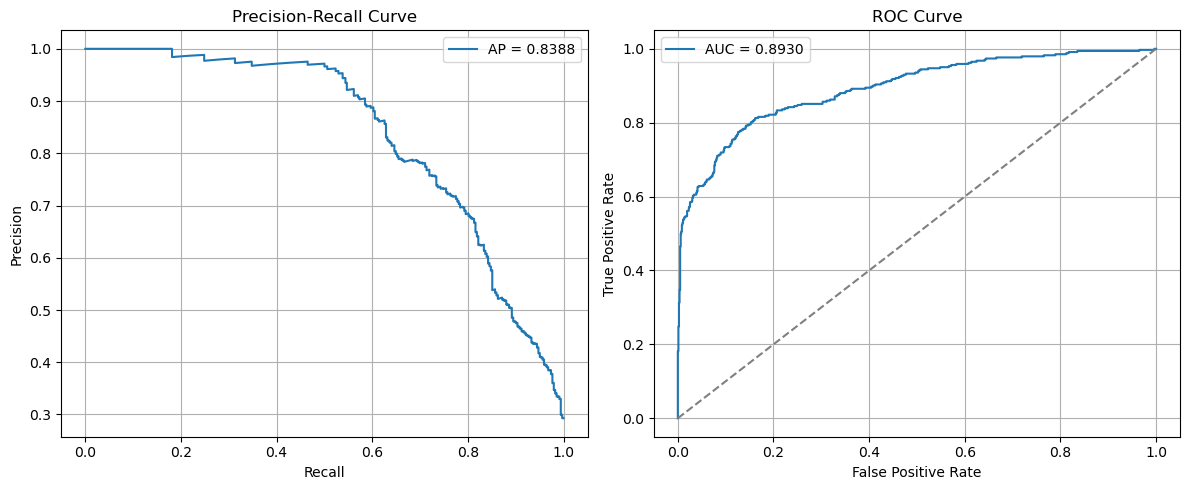

c:\Users\User\anaconda3\envs\torch-gpu\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


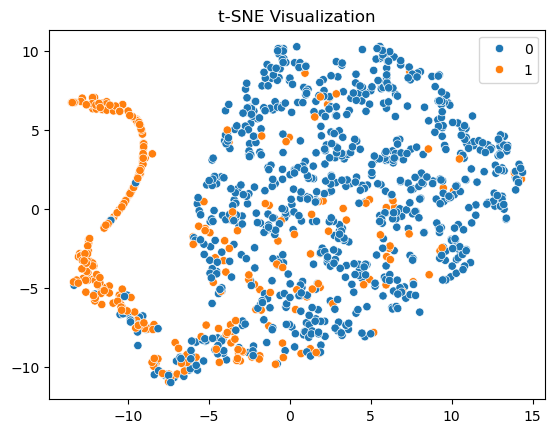

C:\Users\User\AppData\Local\Temp\ipykernel_6460\1766839020.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("msflow_Glow_FocalLoss_Cente

✅ סף שנבחר: 0.1410
Recall = 0.8918, Precision = 0.5000

🔍 סף בדיקה: 0.1410
🔢 מטריצת בלבול:
[[522 304]
 [ 37 305]]
🎯 דיוק (Precision): 0.5008
🧲 רגישות (Recall): 0.8918
📈 שטח מתחת לעקומת ROC (AUC): 0.8930
📊 ממוצע Precision (AP): 0.8388


100%|██████████| 105/105 [00:07<00:00, 14.54it/s]


🔍 Predictions > 0.14095932245254517: 936 / 1680
AUC: 0.8516 Confusion Matrix:
[[670 450]
 [ 74 486]]
Average Precision (AP): 0.8140
Precision: 0.5192 , Recall: 0.8679


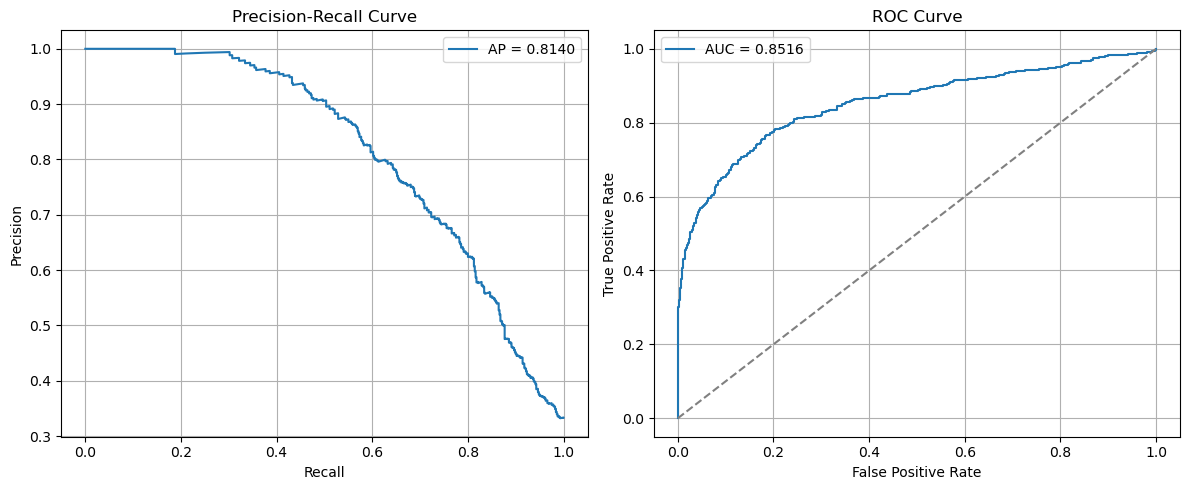

c:\Users\User\anaconda3\envs\torch-gpu\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


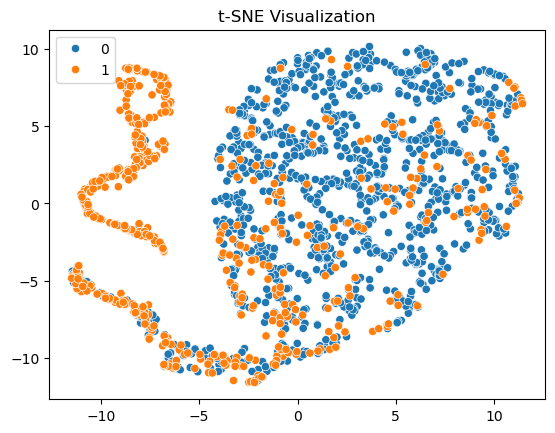

In [8]:
# --- נתיבים ---
data_path = "C:/afeca academy/סימסטר ב/advanced deep learning/project Normalizing Flow/MedlAnaomaly-Data/Camelyon16/Camelyon16"
train_dataset = CamelyonDataset(os.path.join(data_path, "train"), get_transforms(train=True))
validate_dataset = CamelyonDataset(os.path.join(data_path, "validate"), get_transforms(train=True))
test_dataset = CamelyonDataset(os.path.join(data_path, "test"), get_transforms(train=False))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
validate_loader = DataLoader(validate_dataset, batch_size=16, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

# --- ריצה ---
#model = MSFlow().cuda()
#loss_fn = CombinedLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#train_only(model, train_loader, loss_fn, optimizer)
#torch.save(model.state_dict(), 'msflow_Glow_FocalLoss_Center_AugThreshold.pt')
#final_evaluate(model, test_loader)


model = MSFlow().cuda()
model.load_state_dict(torch.load("msflow_Glow_FocalLoss_Center_AugThreshold.pt"))
embeddings, preds, labels, paths = evaluate_msflow(model, validate_loader, threshold=0.35)
best_th = find_best_threshold_by_recall(preds, labels, min_precision=0.5)
evaluate_threshold(preds, labels, best_th)


model = MSFlow().cuda()
model.load_state_dict(torch.load("msflow_Glow_FocalLoss_Center_AugThreshold.pt"))
embeddings, preds, labels, paths = evaluate_msflow(model, test_loader, threshold=best_th)
#best_th = find_best_threshold_by_recall(preds, labels, min_precision=0.5)
#evaluate_threshold(preds, labels, best_th)